In [1]:
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

import seaborn as sns
sns.set(font_scale=2)

In [179]:
path = "../data/rf_data/"
packet = 4
subflow = 5
features = 11
# X_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/X_train_n_"+str(subflow)+"_overlap.npy"
# y_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/y_train_n_"+str(subflow)+"_overlap.npy"
# X_test_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/X_test_n_"+str(subflow)+"_overlap.npy"
# y_test_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/y_test_n_"+str(subflow)+"_overlap.npy"

# X_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/X_train_n_"+str(subflow)+".npy"
# y_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/y_train_n_"+str(subflow)+".npy"
# X_test_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/X_test_n_"+str(subflow)+".npy"
# y_test_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/y_test_n_"+str(subflow)+".npy"

# For comparsion RF vs RL+RF
X_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/X_train_n_"+str(subflow)+"_overlap.npy"
y_train_path = path+"packet_"+str(packet)+"/n_"+str(subflow)+"/y_train_n_"+str(subflow)+"_overlap.npy"
X_test_path = path+"packet_"+str(packet)+"/n_5/X_test_n_5_overlap.npy"
y_test_path = path+"packet_"+str(packet)+"/n_5/y_test_n_5_overlap.npy"

save_path = "./artifacts/"
model_save_path = save_path+"models/RF_model_k_"+str(packet)+"_n_"+str(subflow)+"_f_"+str(features*subflow)+".pkl"
scaler_save_path = save_path+"scalers/scaler_k_"+str(packet)+"_n_"+str(subflow)+"_f_"+str(features*subflow)+".pkl"

In [180]:
# This data is not normalized
X_train = np.load(X_train_path, allow_pickle=True)
y_train = np.load(y_train_path, allow_pickle=True)
X_test = np.load(X_test_path, allow_pickle=True)
y_test = np.load(y_test_path, allow_pickle=True)

In [181]:
np.unique(y_train, return_counts=True)

(array(['attack', 'benign'], dtype='<U6'), array([165435,  39515]))

In [182]:
X_train.shape

(204950, 11)

In [183]:
# Scaling
# scaler = MinMaxScaler(feature_range=[-1,1])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler to a file
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)

In [184]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [185]:
le.transform(["attack", "benign"])

array([0, 1])

In [186]:
RF_model = RandomForestClassifier()

In [187]:
# Train the model on training data
st = time.time()
RF_model.fit(X_train, y_train_encoded) #For sklearn no one hot encoding
print("Training time: ", time.time()-st)

#Now predict using the trained RF model. 
st = time.time()
prediction_RF = RF_model.predict(X_test)
print("inference time per sample: ", (time.time()-st)/len(X_test))
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

Training time:  34.9129478931427
inference time per sample:  7.130407779774767e-06


In [188]:
# Save the trained model
with open(model_save_path, 'wb') as f:
    pickle.dump(RF_model, f)

Accuracy =  0.9964
Precision =  0.9948
Recall =  0.9938
F1 =  0.9943
[[70929   136]
 [  178 16882]]


<Axes: >

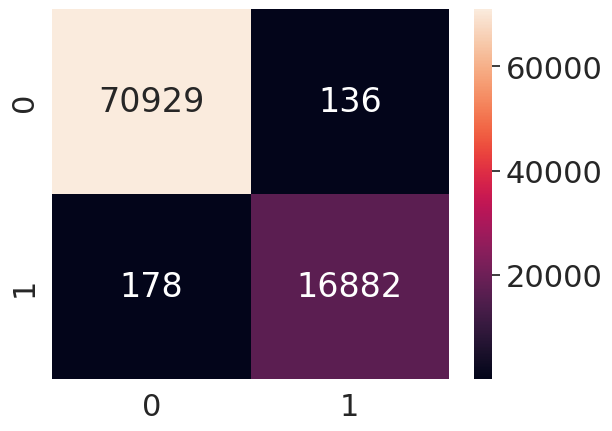

In [189]:
#Print overall accuracy
print("Accuracy = ", round(metrics.accuracy_score(y_test, prediction_RF), 4))
print("Precision = ", round(metrics.precision_score(y_test, prediction_RF, average='macro'),4))
print("Recall = ", round(metrics.recall_score(y_test, prediction_RF, average='macro'),4))
print("F1 = ", round(metrics.f1_score(y_test, prediction_RF, average='macro'), 4))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF) # tn, fp, fn, tp
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

In [190]:
# classification report 
target_names = ["attack", "benign"]
print(classification_report(y_test, prediction_RF, target_names=target_names))

              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     71065
      benign       0.99      0.99      0.99     17060

    accuracy                           1.00     88125
   macro avg       0.99      0.99      0.99     88125
weighted avg       1.00      1.00      1.00     88125



In [191]:
# Save the trained model
# with open(model_save_path, 'rb') as f:
#     RF_model = pickle.load(f)

### Evaluation using voting

In [192]:
y_true_flow = [y_test[i] for i in range(0,len(y_test), subflow)]
y_pred = []
vote = []
random = 0
for i,data in tqdm(enumerate(X_test)):
    inp = data.reshape((1,-1))
    if (i+1)%subflow == 0:
        vote.append(RF_model.predict(inp)[0])
        counter = Counter(vote)
        most_common_value, highest_occurrence = counter.most_common(1)[0]
        if len(counter.most_common())>1 and counter.most_common()[0][1] == counter.most_common()[1][1]:
            random+=1
#         print(most_common_value)
        y_pred.append(le.inverse_transform(np.array([most_common_value]))[0])
        vote = []
    else:
        vote.append(RF_model.predict(inp)[0])
print("random: ", random)
#         print(vote)

88125it [06:56, 211.56it/s]

random:  0


In [193]:
print(len(y_true_flow))
print(len(y_pred))

17625
17625


In [198]:
# y_true_flow.pop(-1)
# y_true_flow.append('benign')

In [199]:
y_pred[0]

'benign'

Accuracy =  0.9981
Precision =  0.9966
Recall =  0.9974
F1 =  0.997
[[14193    20]
 [   13  3399]]


<Axes: >

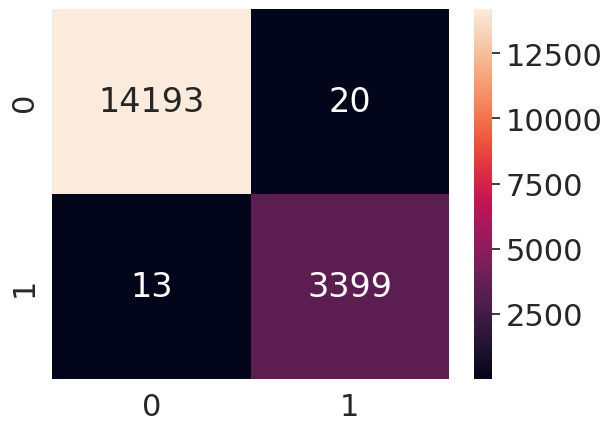

In [200]:
#Print overall accuracy
print("Accuracy = ", round(metrics.accuracy_score(y_true_flow, y_pred), 4))
print("Precision = ", round(metrics.precision_score(y_true_flow, y_pred, average='macro'),4))
print("Recall = ", round(metrics.recall_score(y_true_flow, y_pred, average='macro'),4))
print("F1 = ", round(metrics.f1_score(y_true_flow, y_pred, average='macro'), 4))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_true_flow, y_pred) # tn, fp, fn, tp
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')

In [201]:
# classification report 
target_names = ["attack", "benign"]
print(classification_report(y_true_flow, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     14213
      benign       0.99      1.00      1.00      3412

    accuracy                           1.00     17625
   macro avg       1.00      1.00      1.00     17625
weighted avg       1.00      1.00      1.00     17625



### Confidence score calculation

In [76]:
predictions = RF_model.predict(X_test)

In [124]:
predictions.shape

(11010,)

In [125]:
X_test[0].shape

(11,)

In [17]:
# Getting the proportion of trees that agree on each prediction
confidence_scores = []
for i,data in tqdm(enumerate(X_test)):
    inp = data.reshape((1,-1))
    tree_counter = 0
    for tree in RF_model.estimators_:
        tree_predictions = tree.predict(inp)
        if tree_predictions == predictions[i]:
            tree_counter += 1
    confidence_scores.append(tree_counter)

11010it [01:02, 176.30it/s]


In [18]:
len(confidence_scores)

11010

In [19]:
confidence_scores[0]

63

### Decision path of RF

In [60]:
# Get the decision path for each tree in the forest
decision_paths = []
for i,data in tqdm(enumerate(X_test[0:1])):
    inp = data.reshape((1,-1))
    for tree in RF_model.estimators_:
        sparse_matrix = tree.decision_path(inp)
        decision_paths.append(sparse_matrix.toarray())

1it [00:00, 24.20it/s]


In [63]:
len(decision_paths)

100

In [65]:
decision_paths[1].shape

(1, 913)

In [66]:
decision_paths[1]  # 1 means the sample passes the node, 0 means does not pass

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 